In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import time
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report

from sklearn import metrics as mt
from sklearn.cluster import KMeans

In [2]:
X_train=pd.read_csv("C://Bayesian work//x_train.csv")
X_test=pd.read_csv("C://Bayesian work//x_test.csv")

y_train=pd.read_csv("C://Bayesian work//y_train.csv")
y_test=pd.read_csv("C://Bayesian work//y_test.csv")



In [3]:
training_set= pd.concat([X_train,y_train], axis=1)

In [4]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_train)

KMeans(n_clusters=2)

Text(0, 0.5, 'WCSS')

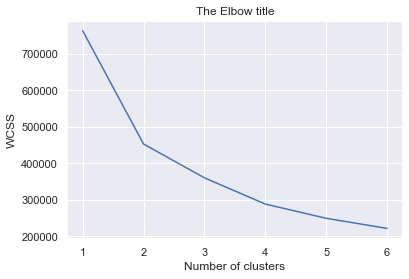

In [7]:
wcss=[]
for i in range(1,7):
    
    kmeans = KMeans(i)
    kmeans.fit(training_set)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)

number_clusters = range(1,7)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [8]:
import numpy as np
from sklearn.cluster import KMeans
from typing import Tuple
def get_clusters(X_train: pd.DataFrame, X_test: pd.DataFrame, n_clusters: int) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    applies k-means clustering to training data to find clusters and predicts them for the test set
    """
    clustering = KMeans(n_clusters=n_clusters, random_state=8675309,n_jobs=-1)
    clustering.fit(X_train)
    # apply the labels
    train_labels = clustering.labels_
    X_train_clstrs = X_train.copy()
    X_train_clstrs['clusters'] = train_labels
    
    # predict labels on the test set
    test_labels = clustering.predict(X_test)
    X_test_clstrs = X_test.copy()
    X_test_clstrs['clusters'] = test_labels
    return X_train_clstrs, X_test_clstrs
X_train_clstrs, X_test_clstrs = get_clusters(X_train, X_test, 2)

In [9]:
############Scaling

In [10]:
from sklearn.preprocessing import StandardScaler
def scale_features(X_train: pd.DataFrame, X_test: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    applies standard scaler (z-scores) to training data and predicts z-scores for the test set
    """
    scaler = StandardScaler()
    to_scale = [col for col in X_train.columns.values]
    scaler.fit(X_train[to_scale])
    X_train[to_scale] = scaler.transform(X_train[to_scale])
    
    # predict z-scores on the test set
    X_test[to_scale] = scaler.transform(X_test[to_scale])
    
    return X_train, X_test
X_train_scaled, X_test_scaled = scale_features(X_train_clstrs, X_test_clstrs)

In [16]:
# to divide the df by cluster, we need to ensure we use the correct class labels, we'll use pandas to do that
train_clusters = X_train_scaled.copy()
test_clusters = X_test_scaled.copy()
train_clusters['y'] = y_train
test_clusters['y'] = y_test

X_train_base = X_train_scaled.drop(columns=['clusters'])
X_test_base = X_test_scaled.drop(columns=['clusters'])

datasets = {
    'base': (X_train_base, y_train, X_test_base, y_test),
    'cluster-feature': (X_train_scaled, y_train, X_test_scaled, y_test),

}

In [17]:

from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn import metrics as mt
def run_exps(datasets: dict) -> pd.DataFrame:
    '''
    runs experiments on a dict of datasets
    '''
    # initialize a XGBoost classifier
    model = XGBClassifier()
    
    dfs = []
    results = []
    conditions = []
    scoring = ['accuracy','precision_weighted','recall_weighted','f1_weighted']
    for condition, splits in datasets.items():
        X_train = splits[0]
        y_train = splits[1]
        X_test = splits[2]
        y_test = splits[3]
        
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(condition)
        print(classification_report(y_test, y_pred))
        print(mt.confusion_matrix(y_test,y_pred))
        
    results.append(cv_results)
    conditions.append(condition)
    this_df = pd.DataFrame(cv_results)
    this_df['condition'] = condition
    dfs.append(this_df)
    final = pd.concat(dfs, ignore_index=True)
    
        # We have wide format data, lets use pd.melt to fix this
    results_long = pd.melt(final,id_vars=['condition'],var_name='metrics', value_name='values')
    
        # fit time metrics, we don't need these
    time_metrics = ['fit_time','score_time'] 
    results = results_long[~results_long['metrics'].isin(time_metrics)] # get df without fit data
    results = results.sort_values(by='values')
    
    return results
df = run_exps(datasets)


[14:54:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:54:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:54:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:54:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel